# Processing airport changes during ourbreat of COVID-19

### Load Python tools

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import geojson
import altair as alt
from shapely.geometry import Point, LineString
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')

ThemeRegistry.enable('latimes')

### Read airport data

In [2]:
# https://datahub.io/core/airport-codes#data
airports = pd.read_csv('input/airport-codes_csv.csv', encoding='latin-1')

### Split coordinates

In [3]:
airports['coordinates'] = airports.coordinates.str.replace('(', '').str.replace(')', '')

lat = []
lon = []

for row in airports['coordinates']:
    try:
        lat.append(row.split(',')[1])
        lon.append(row.split(',')[0])
    except:
        lat.append(np.NaN)
        lon.append(np.NaN)

airports['latitude'] = lat
airports['longitude'] = lon
airports['latitude'] = airports['latitude'].astype(float)
airports['longitude'] = airports['longitude'].astype(float)

### Convert to geodataframe

In [4]:
airports_geo = gpd.GeoDataFrame(
    airports, geometry=gpd.points_from_xy(airports.longitude, airports.latitude))

### Just the 'large' airports

In [5]:
large = airports_geo[airports_geo['type'] == 'large_airport']

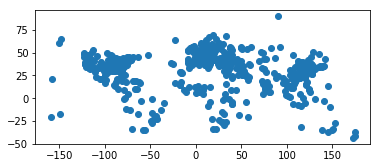

In [6]:
large.plot()

---

## Load flightradar24 airport data

In [7]:
cols_to_use = ['date', 'airport', 'scheduled', 'departed']

### USA flights

In [8]:
usa_src = pd.read_csv('/Users/mhustiles/data/github/notebooks/\
flights-data/coronavirus/US-CAN Airports Scheduled vs Actual.csv',\
                      names=cols_to_use)

### European flights

In [9]:
europe_src = pd.read_csv('/Users/mhustiles/data/github/notebooks/\
flights-data/coronavirus/European Departures Sched vs Actual 14Feb-19Mar.csv',\
                      header=0,names=cols_to_use)

## Basic calculations for flight differences then and now

### USA

In [ ]:
usa_src['diff'] = usa_src['departed'] -  usa_src['scheduled']
usa_src['pct_diff'] = (((usa_src['departed'] - usa_src['scheduled'] )/\
                           usa_src['departed'])*100).round(2)

### Europe

In [11]:
europe_src['diff'] = europe_src['departed'] -  europe_src['scheduled']
europe_src['pct_diff'] = (((europe_src['departed'] - europe_src['scheduled'] )/\
                           europe_src['departed'])*100).round(2)

### LAX 

In [152]:
lax = usa_src[usa_src['airport'] == 'LAX']
lax.head()

date airport  scheduled  departed  diff  pct_diff
13   2/17/20     LAX        894       872   -22     -2.52
41   2/18/20     LAX        947       915   -32     -3.50
69   2/19/20     LAX        912       888   -24     -2.70
97   2/20/20     LAX        925       905   -20     -2.21
125  2/21/20     LAX        936       911   -25     -2.74

In [167]:
alt.Chart(lax).mark_bar(size=15,color='#f03b20').encode(
    x=alt.X('date:T', title='', axis=alt.Axis(tickCount=6, format='%b %d')),
    y=alt.Y('diff:Q', title='')
).properties(width=800, height=400,
    title='Daily decrease in total LAX flights'
)

alt.Chart(...)

### Merge with airports list to get metadata about each one

In [12]:
usa_merge = usa_src.merge(airports_geo, right_on='iata_code', left_on='airport', how='left')
europe_merge = europe_src.merge(airports_geo, right_on='iata_code', left_on='airport', how='left')

In [13]:
usa_merge.head()

date airport  scheduled  departed  diff  pct_diff ident           type  \
0  2/17/20     ATL       1159      1152    -7     -0.61  KATL  large_airport   
1  2/17/20     BOS        578       530   -48     -9.06  KBOS  large_airport   
2  2/17/20     BWI        322       315    -7     -2.22  KBWI  large_airport   
3  2/17/20     CLT        829       826    -3     -0.36  KCLT  large_airport   
4  2/17/20     DEN        856       843   -13     -1.54  KDEN  large_airport   

                                                name  elevation_ft  ...  \
0   Hartsfield Jackson Atlanta International Airport        1026.0  ...   
1  General Edward Lawrence Logan International Ai...          20.0  ...   
2  Baltimore/Washington International Thurgood Ma...         146.0  ...   
3            Charlotte Douglas International Airport         748.0  ...   
4                       Denver International Airport        5431.0  ...   

  iso_country iso_region municipality gps_code iata_code local_code  \
0          US      US-GA      Atlanta     KATL       ATL        ATL   
1          US      US-MA       Boston     KBOS       BOS        BOS   
2          US      US-MD    Baltimore     KBWI       BWI        BWI   
3          US      US-NC    Charlotte     KCLT       CLT        CLT   
4          US      US-CO       Denver     KDEN       DEN        DEN   

                            coordinates   latitude   longitude  \
0                   -84.428101, 33.6367  33.636700  -84.428101   
1             -71.00520325, 42.36429977  42.364300  -71.005203   
2                   -76.668297, 39.1754  39.175400  -76.668297   
3  -80.94309997558594, 35.2140007019043  35.214001  -80.943100   
4       -104.672996521, 39.861698150635  39.861698 -104.672997   

                      geometry  
0   POINT (-84.42810 33.63670)  
1   POINT (-71.00520 42.36430)  
2   POINT (-76.66830 39.17540)  
3   POINT (-80.94310 35.21400)  
4  POINT (-104.67300 39.86170)  

[5 rows x 21 columns]

---

## Aggregate change at European and American airports

In [14]:
d = dict.fromkeys(('scheduled', 'departed'), ['mean', 'sum'])

### Change in average daily flights and total flights in the United States

In [15]:
usa_agg = usa_src.groupby('airport').agg(d).round(2).reset_index()
usa_agg.columns = ['_'.join(col) for col in usa_agg.columns.values]

In [16]:
usa_agg['sum_diff'] = usa_agg.departed_sum - usa_agg.scheduled_sum
usa_agg['pct_diff'] = (((usa_agg.departed_sum - usa_agg.scheduled_sum)/
                        usa_agg.departed_sum)*100).round(2)

In [17]:
usa_agg.head()

airport_  scheduled_mean  scheduled_sum  departed_mean  departed_sum  \
0      ATL         1242.53          39761        1214.09         38851   
1      BOS          619.53          19825         555.88         17788   
2      BWI          340.00          10880         327.53         10481   
3      CLT          820.81          26266         799.91         25597   
4      DEN          889.19          28454         858.03         27457   

   sum_diff  pct_diff  
0      -910     -2.34  
1     -2037    -11.45  
2      -399     -3.81  
3      -669     -2.61  
4      -997     -3.63

### Change in average daily flights and total flights in the Europe

In [18]:
europe_agg = europe_src.groupby('airport').agg(d).round(2).reset_index()
europe_agg.columns = ['_'.join(col) for col in europe_agg.columns.values]

In [19]:
europe_agg['sum_diff'] = europe_agg.departed_sum - europe_agg.scheduled_sum
europe_agg['pct_diff'] = (((europe_agg.departed_sum - europe_agg.scheduled_sum)/
                        europe_agg.departed_sum)*100).round(2)

In [ ]:
europe_agg.head()

### Change by day in USA flights

In [119]:
usa_date_agg = usa_src.groupby('date').agg(d).round(2).reset_index()

In [120]:
usa_date_agg.columns = ['_'.join(col) for col in usa_date_agg.columns.values]

In [121]:
usa_date_agg['sum_diff'] = usa_date_agg.departed_sum - usa_date_agg.scheduled_sum
usa_date_agg['pct_diff'] = (((usa_date_agg.departed_sum - usa_date_agg.scheduled_sum)/
                        usa_date_agg.departed_sum)*100).round(2)

In [122]:
usa_date_agg.head()

date_  scheduled_mean  scheduled_sum  departed_mean  departed_sum  \
0  2/17/20          618.57          17320         605.32         16949   
1  2/18/20          644.71          18052         625.68         17519   
2  2/19/20          638.89          17889         623.50         17458   
3  2/20/20          650.82          18223         632.93         17722   
4  2/21/20          656.61          18385         638.29         17872   

   sum_diff  pct_diff  
0      -371     -2.19  
1      -533     -3.04  
2      -431     -2.47  
3      -501     -2.83  
4      -513     -2.87

In [123]:
alt.Chart(usa_date_agg).mark_bar(size=15,color='#f03b20').encode(
    x=alt.X('date_:T', title='', axis=alt.Axis(tickCount=6, format='%b %d')),
    y=alt.Y('sum_diff:Q', title='Flight descrease')
).properties(width=800, height=400,
    title='Daily decrease in total U.S. flights'
)

alt.Chart(...)

In [124]:
europe_date_agg = europe_src.groupby('date').agg(d).round(2).reset_index()

In [125]:
europe_date_agg.columns = ['_'.join(col) for col in europe_date_agg.columns.values]

In [126]:
europe_date_agg['sum_diff'] = europe_date_agg.departed_sum - europe_date_agg.scheduled_sum
europe_date_agg['pct_diff'] = (((europe_date_agg.departed_sum - europe_date_agg.scheduled_sum)/
                        europe_date_agg.departed_sum)*100).round(2)

In [127]:
europe_date_agg.head()

date_  scheduled_mean  scheduled_sum  departed_mean  departed_sum  \
0  2/14/20          330.77           9923         324.87          9746   
1  2/15/20          284.42           8817         273.84          8489   
2  2/16/20          332.71          10314         315.06          9767   
3  2/17/20          332.94          10321         323.84         10039   
4  2/18/20          303.52           9409         296.00          9176   

   sum_diff  pct_diff  
0      -177     -1.82  
1      -328     -3.86  
2      -547     -5.60  
3      -282     -2.81  
4      -233     -2.54

In [128]:
alt.Chart(europe_date_agg).mark_bar(size=15,color='#f03b20').encode(
    x=alt.X('date_:T', title='', axis=alt.Axis(tickCount=6, format='%b %d')),
    y=alt.Y('sum_diff:Q', title='Flight descrease')
).properties(width=800, height=400,
    title='Daily decrease in total European flights'
)

alt.Chart(...)

---

In [165]:
alt.Chart(usa_src).mark_bar(color='#f03b20', size=3).encode(
    x=alt.X('date:T', title='', axis=alt.Axis(tickCount=3, format='%b %d')),
    y=alt.Y('diff:Q', title='')
).properties(width=100, height=90).facet(
    facet=alt.Facet('airport:N', title='Airport'),
    columns=7,
    title='Daily reduction in scheduled flights, by U.S. airport'
)

alt.FacetChart(...)

In [166]:
alt.Chart(europe_src).mark_bar(color='#f03b20', size=3).encode(
    x=alt.X('date:T', title='', axis=alt.Axis(tickCount=3, format='%b-%d')),
    y=alt.Y('diff:Q', title='')
).properties(width=100, height=90).facet(
    facet=alt.Facet('airport:N', title='Airport'),
    columns=7,
    title='Daily reduction in scheduled flights, by European airport'
)

alt.FacetChart(...)

---